In [2]:
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy import API
from tweepy import Cursor
from textblob import TextBlob

import TwitterCreds
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
"""Twitter Client"""
class TwitterClient():
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)
        
        self.twitter_user = twitter_user
        
    def get_twitter_client_api(self):
        return self.twitter_client
        
    def get_user_timeline_tweets(self,num_tweets):
        user_timeline_tweets = []
        for tweet in Cursor(self.twitter_client.user_timeline,id=self.twitter_user).items(num_tweets):
            user_timeline_tweets.append(tweet)
        return user_timeline_tweets
    
    def get_user_friends_list(self,num_friends):
        user_friends_list = []
        for friend in Cursor(self.twitter_client.friends,id=self.twitter_user).items(num_friends):
            user_friends_list.append(friend)
        return user_friends_list
    
    def get_home_timeline_tweets(self,num_tweets):
        home_timeline_tweets = []
        for tweet in Cursor(self.twitter_client.home_timeline,id=self.twitter_user).items(num_tweets):
            home_timeline_tweets.append(tweet)
        return home_timeline_tweets

"""Twitter Authenticator"""
class TwitterAuthenticator():
    def authenticate_twitter_app(self):
        auth = OAuthHandler(TwitterCreds.CONSUMER_KEY, TwitterCreds.CONSUMER_SECRET)
        auth.set_access_token(TwitterCreds.ACCESS_TOKEN, TwitterCreds.ACCESS_TOKEN_SECRET)
        return auth

"""Twitter Streamer Class"""
class TwitterStreamer():
    """Class for listening and streaming live tweets."""
    def __init__(self):
        self.twitter_authenticator = TwitterAuthenticator()
        
    def stream_tweets(self,fetched_tweets_filename,hash_tag_list):
        """This method handles the Twitter Authentication and provides connection to the Twitter APIs."""
        listener = TwitterListener(fetched_tweets_filename)
        auth = self.twitter_authenticator.authenticate_twitter_app()
        stream = Stream(auth, listener)
        """This line filters Twitter stream based on a keyword"""
        stream.filter(track = hash_tag_list)
        
"""Twitter stream listener"""
class TwitterListener(StreamListener):
    """This is a basic class that just prints received tweets to stdout."""
    def __init__(self,fetched_tweets_filename):
        self.fetched_tweets_filename = fetched_tweets_filename
        
    def on_data(self,data):
        try:
            #print(data)
            with open(self.fetched_tweets_filename, 'a') as tf:
                tf.write(data)
            return True
        except BaseException as e:
            print("Error on Data: {}".format(str(e)))
        return True
    def on_error(self,status):
        """Check if the Twitter returns an error with status as 420. This means DO NOT use this app anymore"""
        if status == 420:
            return False
        print(status)

class TweetAnalyzer():
    """Class having functionality to analyse and categorise content from the tweets"""
    
    def clean_tweet(self,tweet):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",tweet).split())
    
    def analyse_sentiment(self,tweet):
        analysis = TextBlob(self.clean_tweet(tweet))
        
        if analysis.sentiment.polarity > 0:
            return 1
        elif analysis.sentiment.polarity == 0:
            return 0
        else:
            return -1
    
    def tweets_to_data_frame(self,tweets):
        df = pd.DataFrame(data=[tweet.text for tweet in tweets],columns=["tweets"])
        df["id"] = np.array([tweet.id for tweet in tweets])
        df["len"] = np.array([len(tweet.text) for tweet in tweets])
        df["date"] = np.array([tweet.created_at for tweet in tweets])
        df["source"] = np.array([tweet.source for tweet in tweets])
        df["likes"] = np.array([tweet.favorite_count for tweet in tweets])
        df["retweets"] = np.array([tweet.retweet_count for tweet in tweets])
        return df
    

135.5
867
82
                                              tweets                   id  \
0  West Bengal: BJP workers showed black flags to...  1331283917496741889   
1  RT @ANINewsUP: Maulana Kalbe Sadiq, vice-chair...  1331281974288236546   
2  Delhi reported 6,224 new #COVID19 cases (out o...  1331279007048843264   
3  In a supplementary charge sheet filed in a cou...  1331278067164094466   
4  RT @AHindinews: कहीं रात 9 बजे से कहीं रात 10 ...  1331275793276669953   
5  17 dead, at least 50 injured in blasts in Bami...  1331275242015137792   
6  Appointments Committee of the Cabinet has appr...  1331272056671932418   
7  #CycloneNivar over southwest Bay of Bengal mov...  1331270502443192321   
8  Police check vehicles entering Delhi from Utta...  1331268907244560386   
9  5 trains cancelled, 7 trains short terminated/...  1331268513395195905   

   len                date           source  likes  retweets  sentiment  
0  140 2020-11-24 17:09:54  Twitter Web App    477        29     

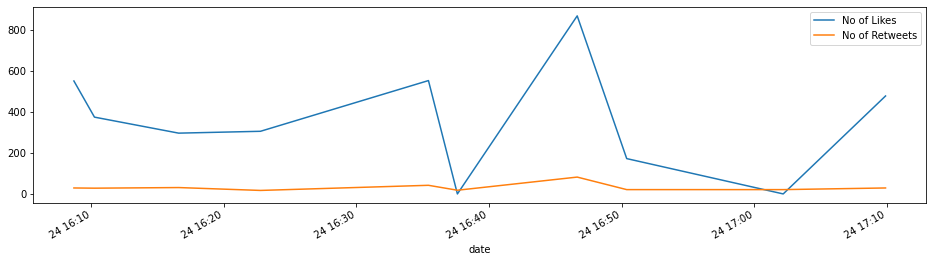

In [7]:
if __name__ == "__main__":
    twitter_client = TwitterClient()
    api = twitter_client.get_twitter_client_api()
    tweet_analyser = TweetAnalyzer()
    tweets = api.user_timeline(screen_name="ANI",count=10)
    df = tweet_analyser.tweets_to_data_frame(tweets)
    df['sentiment'] = np.array([tweet_analyser.analyse_sentiment(tweet) for tweet in df['tweets']])
    
#     Get the average length of the tweets
    print(np.mean(df['len']))
    
#     Get the number of likes for the most liked tweet
    print(np.max(df['likes']))
    
#     Get the number of retweets for the most retweeted tweet
    print(np.max(df['retweets']))
    
    print(df.head(10))
    
    #Time Series Plotting
    time_likes = pd.Series(data=df['likes'].values,index=df['date'])
    time_likes.plot(figsize=(16,4),label="No of Likes", legend=True)
    
    time_likes = pd.Series(data=df['retweets'].values,index=df['date'])
    time_likes.plot(figsize=(16,4),label="No of Retweets", legend=True)
    
    plt.show()